In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

from constants import *

In [2]:
dfs_events = dict()
dfs_samples = dict()

FILE_TYPE_EVENTS = 'events'
FILE_TYPE_SAMPLES = 'samples'

for f in sorted(listdir('.')):
    if f.startswith('recording_'):
        # print(f)
        file_prefix, file_ID, file_ending = f.split('_')
        file_type, file_extension = file_ending.split('.')
        print(file_prefix, file_ID, file_type)

        if file_type == FILE_TYPE_EVENTS:
            dfs_events[file_ID] = pd.read_csv(f)
        if file_type == FILE_TYPE_SAMPLES:
            dfs_samples[file_ID] = pd.read_csv(f)

recording 2025-05-06 09:15:43 events
recording 2025-05-06 09:15:43 samples


(np.float64(39.09549217224121), np.float64(50.38555641174317))

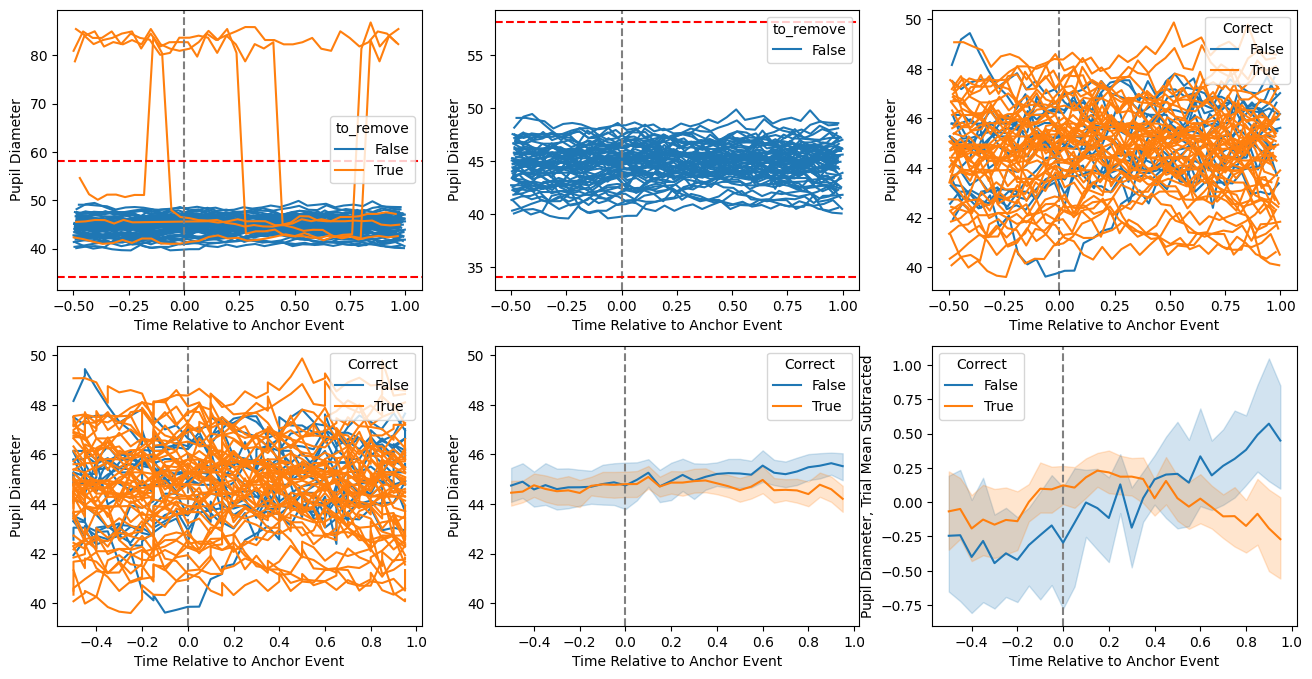

In [6]:
for file_ID, df_events in dfs_events.items():
    
    # Make sure samples are also in directory, also make sure that it's not just an empty session
    if not file_ID in dfs_samples or len(df_events) == 0:
        continue

    df_samples = dfs_samples[file_ID]

    if df_events[cn_TRIAL_IDX].isna().any():
        df_events[cn_TRIAL_IDX] = df_events.index

    # display(df_events, df_samples)
    mean_pupil_diam = 0

    col_cond = cn_RESULT_CORRECTNESS # Used for grouping traces by experimental condition

    anchor_event = cn_TIME_REWARD
    # anchor_offsets = (-0.500, +0.500)
    anchor_offsets = (-0.500, +1.000)
    anchor_offset_beg, anchor_offset_end = anchor_offsets
    dfs_relevant_samples = dict()
    for trial_idx, t0 in zip(df_events[cn_TRIAL_IDX], df_events[anchor_event]):
        t_beg, t_end = t0 + anchor_offset_beg, t0 + anchor_offset_end
        relevant_samples_range = (df_samples[cn_TIMESTAMP] >= t_beg), (df_samples[cn_TIMESTAMP] <= t_end)
        cond_beg, cond_end = relevant_samples_range
        relevant_samples = df_samples.loc[cond_beg & cond_end].copy()
        relevant_samples[cn_TIME_REL_ANCHOR] = relevant_samples[cn_TIMESTAMP] - t0
        relevant_samples[cn_TRIAL_IDX] = trial_idx
        relevant_samples['to_remove'] = False

        if not col_cond is None:
            row_events = df_events.loc[df_events[cn_TRIAL_IDX] == trial_idx]
            # display(row_events[col_cond])
            relevant_samples[col_cond] = row_events[col_cond].values[0] # having to use .values[0] is silly, literally just accessing the one element present
            # display(relevant_samples)

        dfs_relevant_samples[trial_idx] = relevant_samples

    ## Heuristically remove trials with outlier pupil diameters (i.e. filter out artifacts)

    relevant_samples_concat = pd.concat(dfs_relevant_samples.values())
    # dfs_relevant_samples['to_remove'] = False
    pupil_diam_all = relevant_samples_concat[cn_PUPIL_DIAM]
    pupil_diam_mean = np.mean(pupil_diam_all)
    pupil_diam_var = np.var(pupil_diam_all)
    pupil_diam_l1 = np.linalg.norm(pupil_diam_all - pupil_diam_mean, ord=1) / len(pupil_diam_all) # normalize before taking L1 measure

    # remove_range_low, remove_range_high = pupil_diam_mean - 2*pupil_diam_var, pupil_diam_mean + 2*pupil_diam_var
    num_l1_norms = 4
    remove_range_low, remove_range_high = pupil_diam_mean - num_l1_norms*pupil_diam_l1, pupil_diam_mean + num_l1_norms*pupil_diam_l1
    # print(remove_range_low, remove_range_high)
    
    for trial_idx, df in dfs_relevant_samples.items():
        suspicious_samples = (df[cn_PUPIL_DIAM] < remove_range_low) | (df[cn_PUPIL_DIAM] > remove_range_high)
        if suspicious_samples.any():
            df['to_remove'] = True

        suspicious_samples = (df[cn_PUPIL_DIAM] < pupil_diam_mean - 50) | (df[cn_PUPIL_DIAM] > pupil_diam_mean + 50 )
        if suspicious_samples.any():
            df['to_remove'] = True




    # Plotting
    nrows, ncols = 2, 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(w=16, h=8)

    axs_counter = 0
    axs_idx_r, axs_idx_c = axs_counter // ncols, axs_counter % ncols

    # Show 2 figures, one before removing outliers, one after
    for i in range(2):
        if not i == 0:
            # Show figure after removing outliers
            for trial_idx, df in dfs_relevant_samples.items():
                dfs_relevant_samples[trial_idx] = df.loc[df['to_remove'] == False]    
    
        relevant_samples_concat = pd.concat(dfs_relevant_samples.values())
        relevant_samples_concat.reset_index(inplace=True, drop=True)

        # display(relevant_samples_concat)

        # Do this every time we want to advance to the next ax
        axs_idx_r, axs_idx_c = axs_counter // ncols, axs_counter % ncols
        a = axs[axs_idx_r][axs_idx_c]
        axs_counter += 1

        sb.lineplot(data=relevant_samples_concat, x=cn_TIME_REL_ANCHOR, y=cn_PUPIL_DIAM, units=cn_TRIAL_IDX, estimator=None, hue='to_remove', ax=a) # estimator=None when grouping, missing feature in sb
        a.axvline(x=0, linestyle='--', color='gray')
        a.axhline(y=remove_range_low, linestyle='--', color='red')
        a.axhline(y=remove_range_high, linestyle='--', color='red')

    # Once we have filtered out the suspicious samples, hue them according to whether they were correct or incorrect trials
   
    
    # Do this every time we want to advance to the next ax
    axs_idx_r, axs_idx_c = axs_counter // ncols, axs_counter % ncols
    a = axs[axs_idx_r][axs_idx_c]
    axs_counter += 1
    a.axvline(x=0, linestyle='--', color='gray')
    sb.lineplot(data=relevant_samples_concat, x=cn_TIME_REL_ANCHOR, y=cn_PUPIL_DIAM, units=cn_TRIAL_IDX, estimator=None, hue=col_cond, ax=a)
    y_lim_traces = a.get_ylim() # store the ylims of this plot, as they can be used for further plots for clarity and consistency
    display(a.get_ylim())

    ## Show binned traces
    # And once we have shown traces individually, bin them every 50ms or so and now use the mean estimator (default, just don't give estimator a value)
    bin_size = 0.050 # 50ms
    dfs_relevant_samples_binned = dict()
    for trial_idx, df in dfs_relevant_samples.items():
        df_binned = df.copy()
        timestamps_original = np.array(df_binned[cn_TIME_REL_ANCHOR])
        timestamps_binned = np.floor(timestamps_original / bin_size) * bin_size # divides by bin size to get timestamps into integer magnitudes, rounds down, then returns to magnitude
        df_binned[cn_TIME_REL_ANCHOR] = timestamps_binned
        dfs_relevant_samples_binned[trial_idx] = df_binned

    dfs_to_concat = dfs_relevant_samples_binned
    df_to_plot = pd.concat(dfs_to_concat.values())
    df_to_plot.reset_index(inplace=True, drop=True)

    # Do this every time we want to advance to the next ax
    axs_idx_r, axs_idx_c = axs_counter // ncols, axs_counter % ncols
    a = axs[axs_idx_r][axs_idx_c]
    axs_counter += 1
    a.set_ylim(y_lim_traces)
    a.axvline(x=0, linestyle='--', color='gray')
    sb.lineplot(data=df_to_plot, x=cn_TIME_REL_ANCHOR, y=cn_PUPIL_DIAM, units=cn_TRIAL_IDX, estimator=None, hue=col_cond, ax=a)

    ## Show mean trajectory of binned traces (should be clear that leading up to selection time pupil diam is about the same between correct and incorrect)
    # Do this every time we want to advance to the next ax
    axs_idx_r, axs_idx_c = axs_counter // ncols, axs_counter % ncols
    a = axs[axs_idx_r][axs_idx_c]
    axs_counter += 1
    a.set_ylim(y_lim_traces)
    a.axvline(x=0, linestyle='--', color='gray')
    sb.lineplot(data=df_to_plot, x=cn_TIME_REL_ANCHOR, y=cn_PUPIL_DIAM, hue=col_cond, ax=a)

    ## Take mean pupil diam for each trace, demean the traces, and then do the mean trace trajectory again. This should provide a tighter bound without the per-trial bias in pupil size
    # Do this every time we want to advance to the next ax
    axs_idx_r, axs_idx_c = axs_counter // ncols, axs_counter % ncols
    a = axs[axs_idx_r][axs_idx_c]
    axs_counter += 1
    a.axvline(x=0, linestyle='--', color='gray')
    
    cn_PUPIL_DIAM_MEAN_TRIAL = f'Pupil Diameter, Trial Mean Subtracted'
    dfs_relevant_samples_demeaned = dict()
    for trial_idx, df in dfs_relevant_samples_binned.items():
        df_demeaned = df.copy()
        df_demeaned[cn_PUPIL_DIAM_MEAN_TRIAL] = df_demeaned[cn_PUPIL_DIAM] - np.mean(df_demeaned[cn_PUPIL_DIAM])
        dfs_relevant_samples_demeaned[trial_idx] = df_demeaned

    dfs_to_concat = dfs_relevant_samples_demeaned
    df_to_plot = pd.concat(dfs_to_concat.values())
    df_to_plot.reset_index(inplace=True, drop=True)

    sb.lineplot(data=df_to_plot, x=cn_TIME_REL_ANCHOR, y=cn_PUPIL_DIAM_MEAN_TRIAL, hue=col_cond, ax=a)